In [1]:
import os
os.chdir("../")

In [2]:
import torch
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from argparse import Namespace
%matplotlib inline

In [3]:
from src.datasets.vanderpol import VanderPol, plot_vanderpol, Data

from src.gpode.model_builder import build_model, compute_loss, compute_predictions, compute_test_predictions
from src.gpode.model_builder import Trainer
from src.gpode.model_initialization import initialize_inducing, initialize_latents_with_data

from src.misc.plot_utils import plot_model_initialization, plot_longitudinal, plot_vectorfield_posterior
from src.misc.settings import settings
from src.misc.torch_utils import numpy2torch, torch2numpy

In [4]:
device = settings.device

if device.type == 'cuda':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [5]:
# setup all the experiment parameters
args = Namespace(**{ 
    'num_features':256,  # number of RFF features for sampling from GP prior
    'num_inducing':16,   # number of inducing points for variational GP posterior
    'q_diag':False,      # diagonal posterior assumption for inducing variables
    'dimwise':True,      # keep separate kernel parameters for ODE transition
    
    'data_obs_S':25,     # observation sequence length for training data
    'data_obs_T':7,      # observation time for training data
    'data_obs_noise_var':0.01, # observation noise std dev
    
    'solver':'dopri5',   # ODE integrator
    'use_adjoint':False, # use adjoint method for gradient computation
    'ts_dense_scale':2,  # number of time steps to evaluate between every observation
    
    'num_iter':100,   # optimization iterations
    'lr':0.001,          # optimization learning rate
     
    'log_freq':20,       # logging frequency
})

### Generating data 

In [6]:
n_ahead = args.data_obs_S
# N= 10
# x0  = np.array([[-0.5, 2.5]])
# x0 = np.random.uniform(-2, 2, size=(N, 2))
# data = VanderPol(S_train=args.data_obs_S, T_train=args.data_obs_T,
#                  S_test=args.data_obs_S + n_ahead,
#                  T_test=(args.data_obs_T * (args.data_obs_S + n_ahead - 1) / (args.data_obs_S - 1)),
#                  noise_var=args.data_obs_noise_var,
#                  x0 = x0,
#                 )

# plot_vanderpol(data)

In [7]:
def load_trajectory_dict(path: str, verbose=True):
    with np.load(path) as _d:
        trajectory_dict = {}
        for key in _d.keys():
            if key[-2:] == "_x":
                if not (key[:-2] + "_t" in _d.keys()):
                    if verbose:
                        print(f"Dataset is missing time values for {key}.")
                    trajectory_dict.update(
                        {
                            key[:-1]: {"X":_d[key], "T":np.linspace(0, 1, _d[key].shape[1])}
                            
                        }
                    )
                else:
                    trajectory_dict.update(
                        {key[:-2]: {"X":_d[key], "T":_d[key[:-2] + "_t"]}}
                    )
    return trajectory_dict

In [8]:
os.getcwd()

'/workspaces/gaussian-process-odes'

In [9]:
data_dict_train = load_trajectory_dict("data/dynamic_sys/volterra_lotka/data_train.dict_traj.npz")
data_dict_test = load_trajectory_dict("data/dynamic_sys/volterra_lotka/data_test.dict_traj.npz")

In [10]:
idx = np.random.choice(np.arange(data_dict_train["exact"]["X"].shape[0]), 10, replace=False)
trn_ts = data_dict_train["exact"]["T"][idx][0, 64:32+64]
trn_ts -= trn_ts[0]
data_train = Data(data_dict_train["exact"]["X"][idx][:, 64:32+64, :], trn_ts)


idx = np.random.choice(np.arange(data_dict_test["exact"]["X"].shape[0]), 10, replace=False)
tst_ts = data_dict_test["exact"]["T"][idx][0, 64:32+64]
tst_ts -= tst_ts[0]
data_test = Data(data_dict_test["exact"]["X"][idx][:, 64:32+64, :], tst_ts)


In [18]:
data_train.ys.min(0).min(0)

array([0.09698116, 0.02895806], dtype=float32)

In [19]:
data_train.ys.max(0).max(0)

array([1.9490393, 0.8773436], dtype=float32)

In [11]:
class Dataset:
    def __init__(self, trn:Data, tst:Data):
        self.trn = trn
        self.tst = tst  
        _min = trn.ys.min(0).min(0)
        _max = trn.ys.max(0).max(0)
        self.xlim = (trn.min(),trn.max())
        self.xlim = (trn.min(),trn.max())
    def f(self, y, t):
        return np.zeros_like(y)

In [12]:
data = Dataset(data_train, data_test)

In [13]:
train_ys = torch.tensor(data.trn.ys)
train_ts = torch.tensor(data.trn.ts)

test_ys = torch.tensor(data.tst.ys)
test_ts = torch.tensor(data.tst.ts)

### Model definition and initialization

We use empirical gradients to initialize the vector field close to ground truth. The following plot shows the GPODE vector field after model initialization.  

In [14]:
model = build_model(args, data.trn.ys)
model = initialize_inducing(model, data.trn.ys, data.trn.ts.max())
model = initialize_latents_with_data(model, data.trn.ys, data.trn.ts)

AttributeError: 'Dataset' object has no attribute 'xlim'

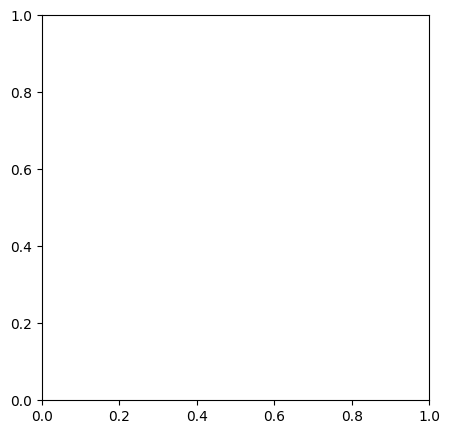

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

plot_model_initialization(ax, data, model, train_ys, train_ts, 
                          compute_predictions, has_latents=False)
ax.set_title('GPODE vector field initialization')
plt.show()

### Optimization

In [ ]:
trainer = Trainer()
model, _ = trainer.train(model = model,
                         loss_function = compute_loss,
                         ys = train_ys, ts = train_ts, 
                         num_iter = args.num_iter, 
                         lr = args.lr, 
                         log_freq = args.log_freq)

In [12]:
print("Observation noise variance:")
print(model.likelihood.variance.data)
print("kernel lengthscales:")
print(model.flow.odefunc.diffeq.kern.lengthscales.data)
print("kernel signal variance:")
print(model.flow.odefunc.diffeq.kern.variance.data)

Observation noise variance:
tensor([0.0567, 0.0568])
kernel lengthscales:
tensor([[1.5221, 1.3501],
        [1.3453, 1.2428]])
kernel signal variance:
tensor([0.4986, 0.5137])


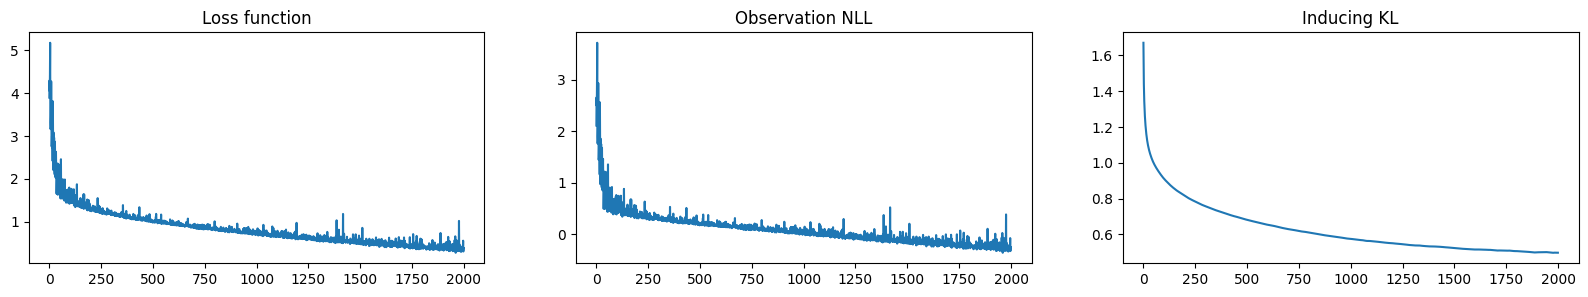

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,3))

ax1.plot(trainer.loss_meter.iters, 
         trainer.loss_meter.vals)
ax1.set_title("Loss function")
ax2.plot(trainer.observ_nll_meter.iters, 
         trainer.observ_nll_meter.vals)
ax2.set_title("Observation NLL")
ax3.plot(trainer.inducing_kl_meter.iters, 
         trainer.inducing_kl_meter.vals)
ax3.set_title("Inducing KL")
plt.show()

### Visualize model predictions

In [14]:
test_pred = torch2numpy(compute_predictions(model, ts=test_ts, eval_sample_size=64))

100%|██████████| 64/64 [00:30<00:00,  2.10it/s]


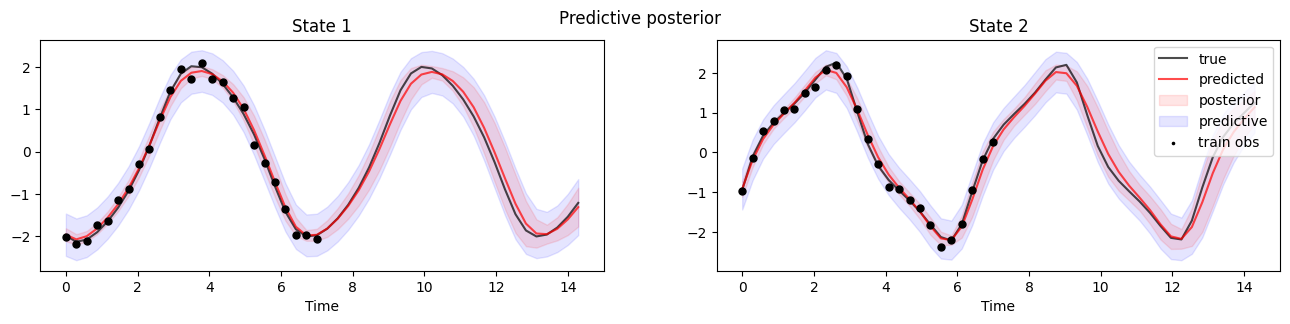

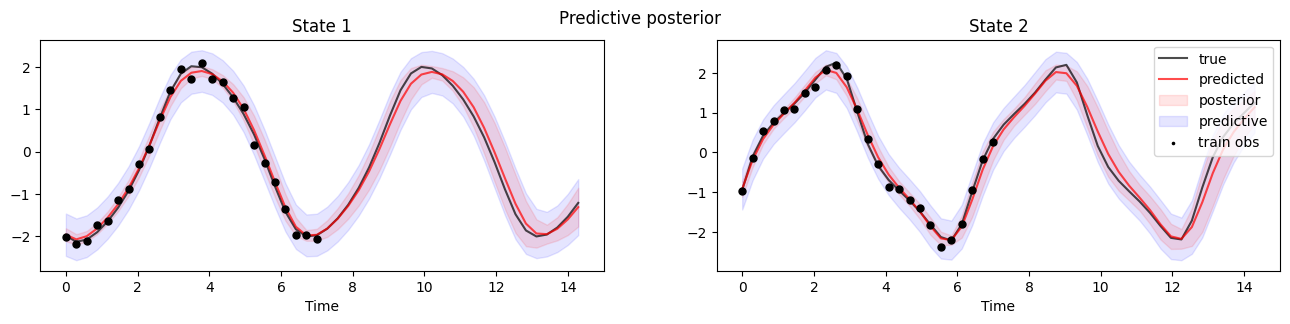

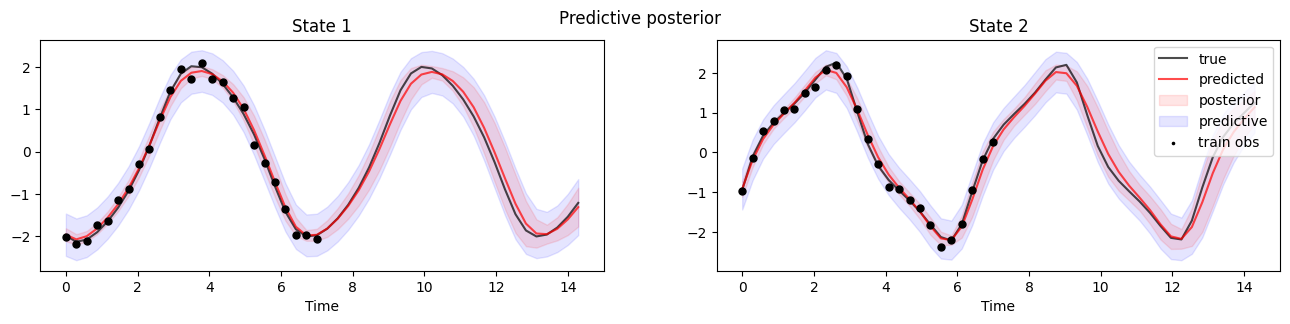

In [15]:
plot_longitudinal(data, test_pred, torch2numpy(model.likelihood.variance))

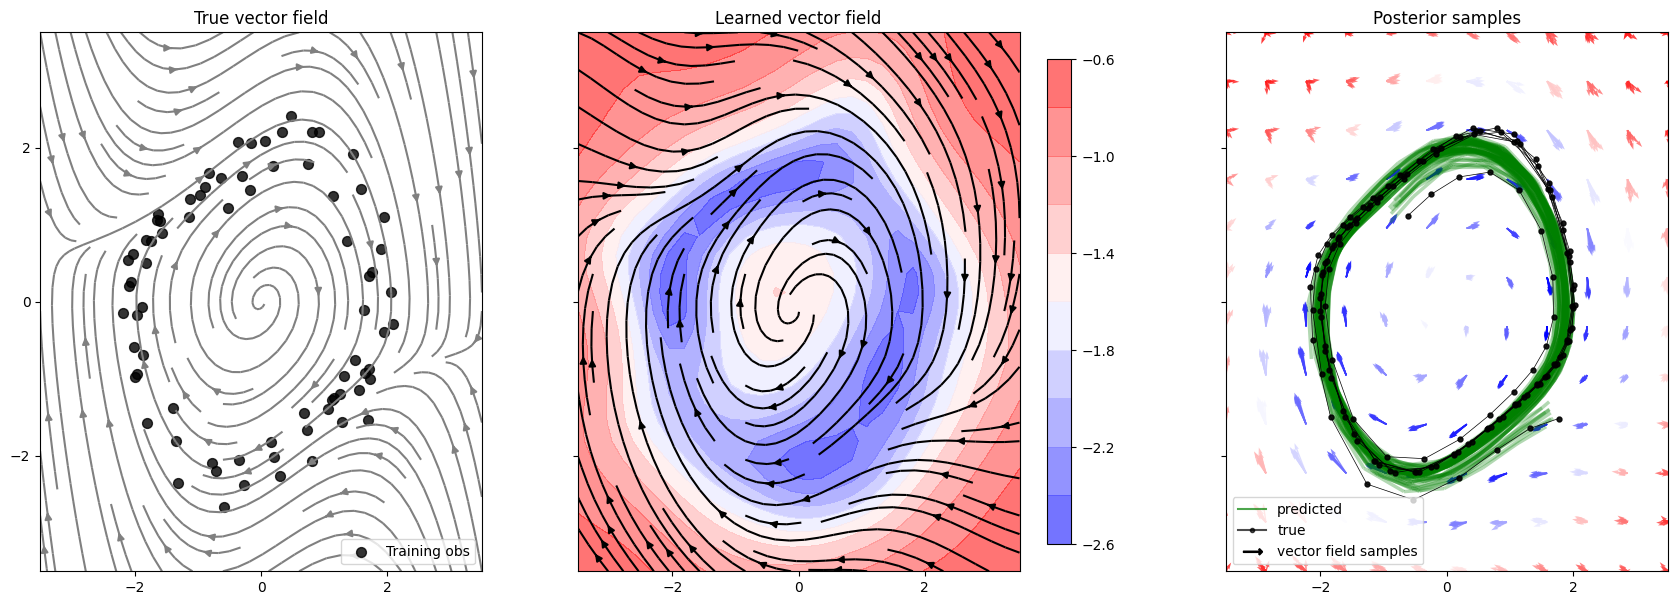

In [16]:
plot_vectorfield_posterior(model, data, test_pred)